In [12]:
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [2]:
target_ts = '2min.parquet'

cwd = os.getcwd()
meta_data = os.path.join(cwd, "..", "data", "raw_data", "metadata.csv")
time_series = os.path.join(cwd, "..", "data", "raw_data", target_ts)

df_energy = pd.read_parquet(time_series)
df_spec = pd.read_csv(meta_data)

gcs_path = 'gs://energy-supply-time-series-data/30min_energy_supply_data.parquet'

df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [9]:
df_energy.head()

,generation_w,timestamp,ss_id
0,11.0,2016-12-01 07:42:27+00:00,3952
1,29.0,2016-12-01 07:42:35+00:00,6125
2,2.0,2016-12-01 07:42:35+00:00,6867
3,4.0,2016-12-01 07:42:36+00:00,3513
4,5.0,2016-12-01 07:42:36+00:00,5660


In [20]:
sample_id = 6125
sample = df_energy[df_energy.ss_id == sample_id]
sample.head()

,generation_w,timestamp,ss_id
1,29.0,2016-12-01 07:42:35+00:00,6125
14,49.0,2016-12-01 07:46:35+00:00,6125
35,112.0,2016-12-01 07:52:35+00:00,6125
91,146.0,2016-12-01 07:56:35+00:00,6125
215,260.0,2016-12-01 08:02:38+00:00,6125


In [16]:
sample_match = df_spec[df_spec.ss_id == sample_id]
sample_match

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
3720,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11


In [17]:
df_energy.head()

,generation_w,timestamp,ss_id
0,11.0,2016-12-01 07:42:27+00:00,3952
1,29.0,2016-12-01 07:42:35+00:00,6125
2,2.0,2016-12-01 07:42:35+00:00,6867
3,4.0,2016-12-01 07:42:36+00:00,3513
4,5.0,2016-12-01 07:42:36+00:00,5660


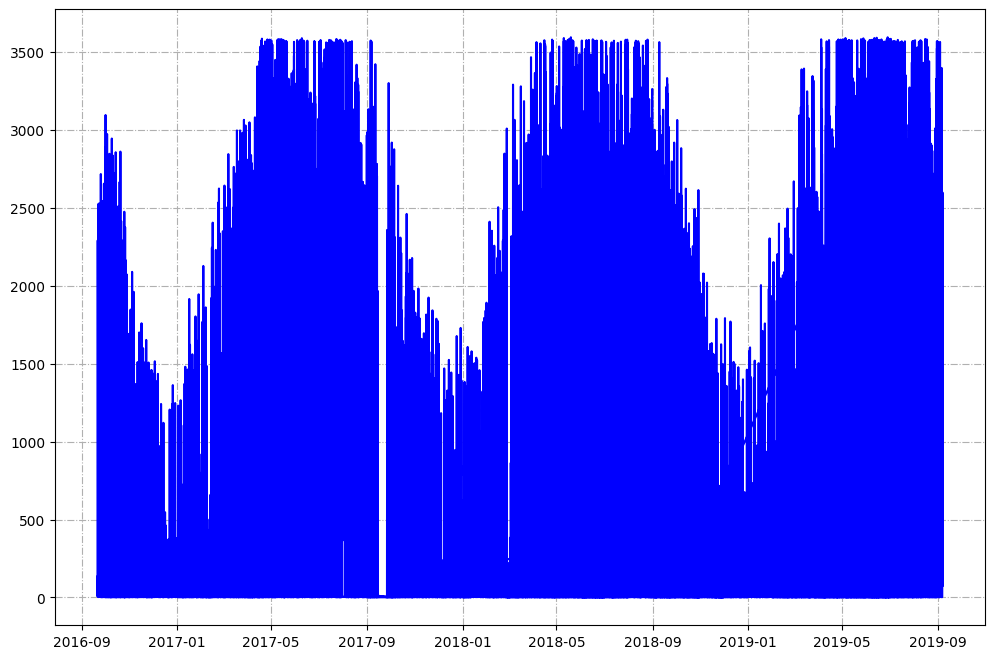

In [19]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(sample['timestamp'], sample['generation_w'], 'b')

In [5]:
df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [54]:
import plotly.express as px
fig = px.scatter_geo(df_spec,lat=df_spec['latitude_rounded'],lon=df_spec['longitude_rounded'], scope="europe",projection="natural earth") 
fig

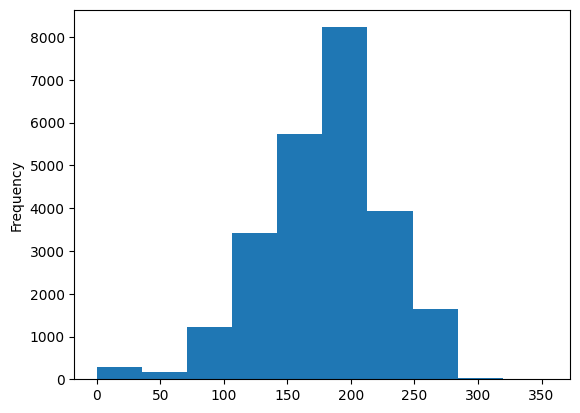

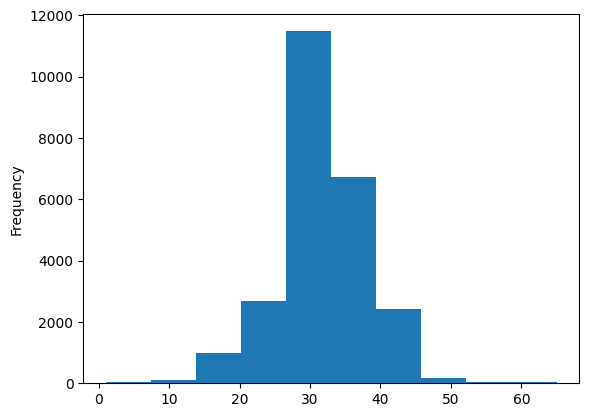

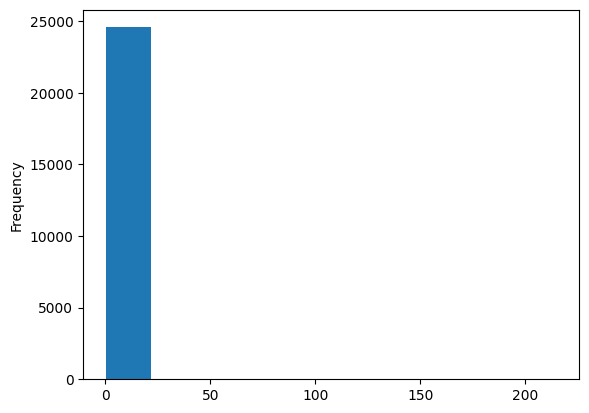

In [25]:
plt.show(df_spec.orientation.plot(kind='hist'))
plt.show(df_spec.tilt.plot(kind='hist'))

Merge the two table and start lookingn for correlations

# Testing Weather

In [3]:
import requests
import pandas as pd 

base_url = 'https://archive-api.open-meteo.com/v1/archive'
params = {
	"latitude": 52.52, # from df_spec
	"longitude": 13.41, # from df_spec
	"start_date": "2024-02-24", # from timeseries 
	"end_date": "2024-03-09", # from timeseries
	"timezone": "Europe/London", # default for london
	"hourly": "weather_code", # OUTPUT
}

responses = requests.get(base_url, params).json()

df = pd.DataFrame({
    'time' : responses['hourly']['time'],
    'weather' : responses['hourly']['weather_code']
    })

In [4]:
df

,time,weather
0,2024-02-24T00:00,2
1,2024-02-24T01:00,2
2,2024-02-24T02:00,2
3,2024-02-24T03:00,1
4,2024-02-24T04:00,1
...,...,...
355,2024-03-09T19:00,0
356,2024-03-09T20:00,0
357,2024-03-09T21:00,0
358,2024-03-09T22:00,0


In [11]:
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'
wmo_description = requests.get(wmo_url).json()

wmo_description['0']['day']['description']

'Sunny'

In [15]:
# Define a function to map weather codes to descriptions
def get_weather_description(weather_code):
    return wmo_description[str(weather_code)]['day']['description']

# Apply the function to create a new column with descriptions
df['description'] = df['weather'].apply(get_weather_description)

df

,time,weather,description
0,2024-02-24T00:00,2,Partly Cloudy
1,2024-02-24T01:00,2,Partly Cloudy
2,2024-02-24T02:00,2,Partly Cloudy
3,2024-02-24T03:00,1,Mainly Sunny
4,2024-02-24T04:00,1,Mainly Sunny
...,...,...,...
355,2024-03-09T19:00,0,Sunny
356,2024-03-09T20:00,0,Sunny
357,2024-03-09T21:00,0,Sunny
358,2024-03-09T22:00,0,Sunny
